#### Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
Для распознавания жестов, вам надо будет скачать датасет для жестов рук. 
Датасет https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import os
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
import seaborn
from facenet_pytorch import MTCNN

#### Загружаем данные

In [2]:
path = 'data/Sign Language MNIST/'

In [3]:
train_data = pd.read_csv(path + 'sign_mnist_train.csv')
test_data = pd.read_csv(path + 'sign_mnist_test.csv')

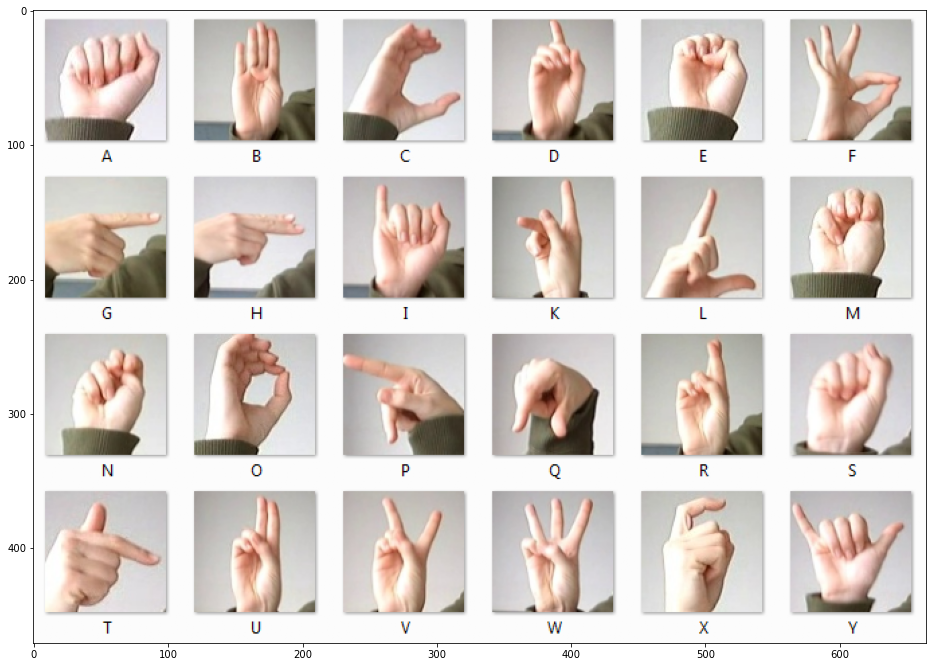

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,16))
img = plt.imread(path + 'amer_sign2.png')
plt.imshow(img)
plt.show()

In [5]:
print('Number samples train:', len(train_data))
print('Number samples test:', len(test_data))

Number samples train: 27455
Number samples test: 7172


In [6]:
train_data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195


##### Словарь меток

In [7]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labels_dict = {idx:letter for idx, letter in enumerate(alphabet)}
train_labels = train_data.label.apply(lambda x: labels_dict[x])
test_labels = test_data.label.apply(lambda x: labels_dict[x])

In [8]:
train_labels = train_data.label.apply(lambda x: labels_dict[x])
test_labels = test_data.label.apply(lambda x: labels_dict[x])

Класс для оборачивания датасета

In [9]:
class customDataset(Dataset):
    # Здесь мы определяем наши данные. Обычно картинки и метки.
    def __init__(self, x, y):
#         self.transforms = tt.ToTensor
        self.x = np.array(x/255.0)
        self.y = np.array(y)
            
    # Так же нужно переопределить метод __len__
    def __len__(self):
        return len(self.x)
    
    # И этот метод в который будет возвращать нам один сэмпл наших данных
    def __getitem__(self, idx):
        """Здесь производим необходимые преобразования над нашими данными"""
        x = self.x[idx]
        x = torch.FloatTensor(x).reshape(1, 28, 28)
        y = self.y[idx]
        y = torch.tensor(y)
        return x, y

In [10]:
train_dataset = customDataset(train_data.drop('label', axis=1), train_data.label)
train_dataloader = DataLoader(train_dataset, batch_size=64)

In [11]:
def show_image(img, label, dataset):
    print(img.size())
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {dataset.y[label]}\nAlpha Label: {labels_dict[dataset.y[label]]}")

torch.Size([1, 28, 28])


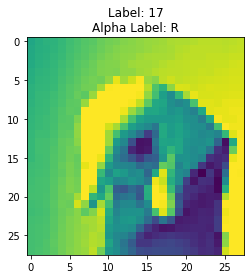

In [12]:
show_image(*train_dataset[5], train_dataset)

In [13]:
test_dataset = customDataset(test_data.drop('label', axis=1), test_data.label)
test_dataloader = DataLoader(test_dataset, batch_size=64)

Функция для просмотра случайных картинок из получившегося датасета:

In [14]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

torch.Size([1, 28, 28])


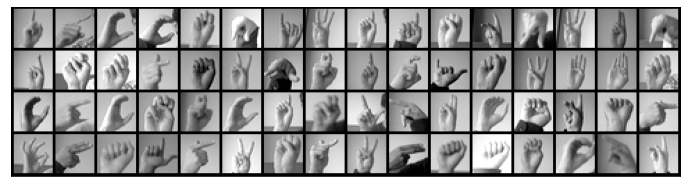

In [15]:
showbatch(train_dataloader)

Функции для перевода моделей и даталоадеров на необходимое оборудование:

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

### Создание модели для распознавания жестов

In [19]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 1*28*28
        self.conv1 = self.conv_block(in_channels, 32)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.res1 = nn.Sequential(self.conv_block(32, 32), self.conv_block(32, 32))
        self.drop1 = nn.Dropout(0.5)
        # 32*14*14
        self.conv3 = self.conv_block(32, 64)
        self.conv4 = self.conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(self.conv_block(64, 64), self.conv_block(64, 64))
        self.drop2 = nn.Dropout(0.5)
        # 64*7*7
        self.conv5 = self.conv_block(64, 128)
        self.conv6 = self.conv_block(128, 128)
        self.res3 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(128, num_classes),
                                        nn.Softmax(dim=1))
        
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out
        

In [20]:
model = to_device(ResNet(1, len(labels_dict)), device)

### Обучение

In [21]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 50
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [22]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 429 total_steps per epoch


In [23]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [24]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data.cuda(), labels.cuda()       
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  3.2538935810258063
Epoch 2, loss:  3.2383637394938436
Epoch 3, loss:  3.1989489913264633
Epoch 4, loss:  3.1150228732671494
Epoch 5, loss:  2.999437506104405
Epoch 6, loss:  2.882763577507926
Epoch 7, loss:  2.8130201720969104
Epoch 8, loss:  2.76088364307697
Epoch 9, loss:  2.7504666668551785
Epoch 10, loss:  2.7145063738167146
Epoch 11, loss:  2.674506684839031
Epoch 12, loss:  2.661993641397614
Epoch 13, loss:  2.6445483088771224
Epoch 14, loss:  2.5777837702166506
Epoch 15, loss:  2.5685814205027406
Epoch 16, loss:  2.501986843166929
Epoch 17, loss:  2.4867505827150143
Epoch 18, loss:  2.484638759862015
Epoch 19, loss:  2.4841217288882027
Epoch 20, loss:  2.484546469641732
Epoch 21, loss:  2.483861137936999
Epoch 22, loss:  2.449947832903384
Epoch 23, loss:  2.4467908446883264
Epoch 24, loss:  2.4418827592631875
Epoch 25, loss:  2.4128191926818348
Epoch 26, loss:  2.392606481805548
Epoch 27, loss:  2.3609321750960985
Epoch 28, loss:  2.325149399973018
Epoch 29, loss

Посмотрим на ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

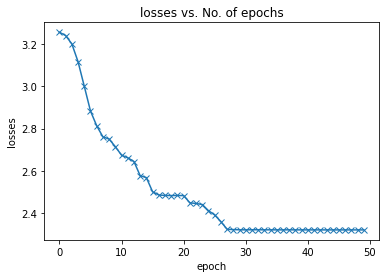

In [25]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [26]:
torch.save(model.state_dict(), 'models/gesture_detection_g_language_50_epochs.pth')

#### Использование модели

In [27]:
net=ResNet(1, len(labels_dict)).to(device)
net.load_state_dict(torch.load('models/gesture_detection_g_language_50_epochs.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Смотрим работу сети на тестовых данных

torch.Size([64, 1, 28, 28])
torch.Size([26])
G


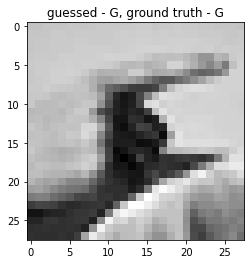

torch.Size([64, 1, 28, 28])
torch.Size([26])
C


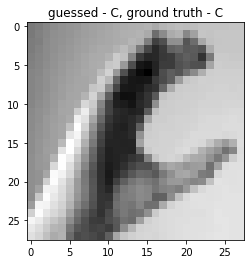

torch.Size([64, 1, 28, 28])
torch.Size([26])
E


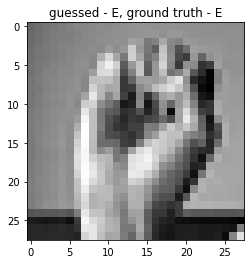

torch.Size([64, 1, 28, 28])
torch.Size([26])
A


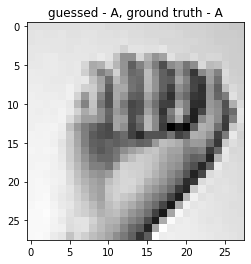

torch.Size([64, 1, 28, 28])
torch.Size([26])
W


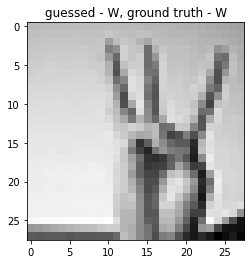

torch.Size([64, 1, 28, 28])
torch.Size([26])
P


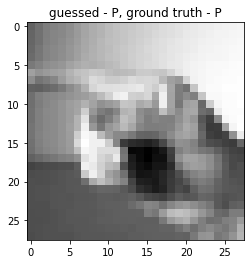

torch.Size([64, 1, 28, 28])
torch.Size([26])
M


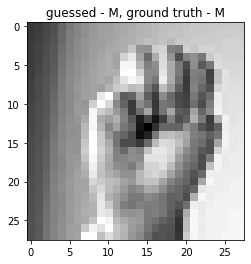

torch.Size([64, 1, 28, 28])
torch.Size([26])
B


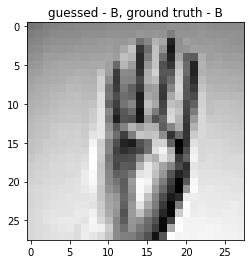

torch.Size([64, 1, 28, 28])
torch.Size([26])
V


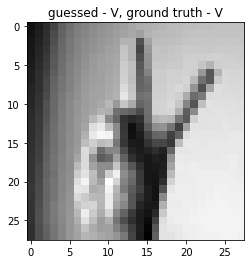

torch.Size([64, 1, 28, 28])
torch.Size([26])
M


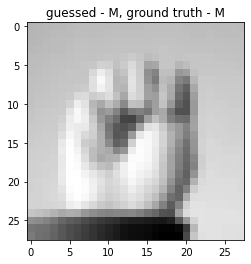

torch.Size([64, 1, 28, 28])
torch.Size([26])
V


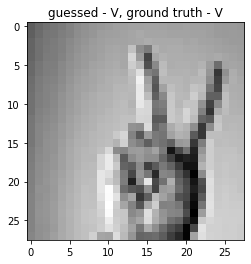

torch.Size([64, 1, 28, 28])
torch.Size([26])
G


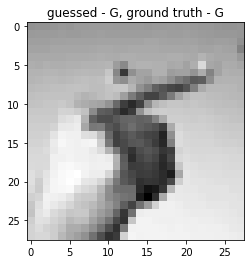

In [28]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        outputs = net(images)
        print(images.shape)
        print(outputs[0].shape)
        print(labels_dict[outputs[0].argmax().item()])
        
        plt.title(f'guessed - {labels_dict[outputs[0].argmax().item()]}, ground truth - {labels_dict[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

Проверяем точность прогнозов

''

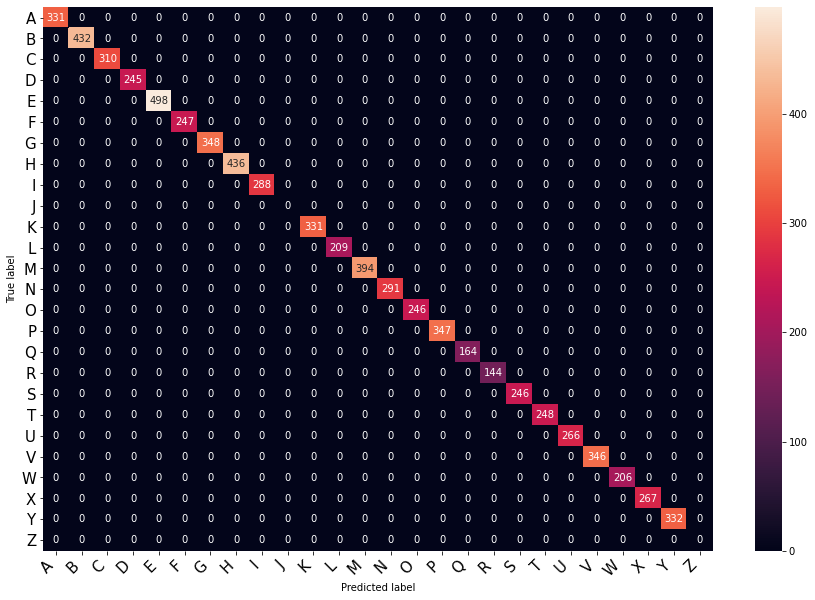

In [29]:
confusion_matrix = torch.zeros(len(labels_dict), len(labels_dict))

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(labels_dict.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

### Прототип приложения для определения жестов человека перед веб-камерой

In [30]:
class FaceDetector(object):

    def __init__(self, mtcnn, emodel, channels=1):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = net
        self.channels = channels

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, gesture):
        try:
            for box in boxes:
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255),
                              thickness=1)

                # пишем на рамке, какой жест распознан
                cv2.putText(frame, 
                    gesture, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                
        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')

        return frame
        
    
    # Функция для вырезания кадра
    @staticmethod
    def crop_hands(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
     # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self): 
        gesture_list = []
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
                # Если лицо обнаружено:
                if ret:
                    # print('Face detected!')
                    # Вырезаем руку из кадра (правая рука - верхний левый угол изображения)
                    hand_crop = self.crop_hands(frame, [[0, 0, 250, 250]])[0]
                    # Меняем размер изображения для входа в нейронную сеть
                    hand_img = cv2.resize(hand_crop,(28,28))
                    # Превращаем в 1-канальное серое изображение
                    hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)

                    # Далее мы подготавливаем наш кадр для считывания нс
                    # Для этого перегоним его в формат pil_image
                    hand = Image.fromarray(hand_img)
                    hand = hand.resize((28,28))
                    hand = np.asarray(hand).astype('float')
                    hand = torch.as_tensor(hand)

                    # Превращаем numpy-картинку вырезанной руки в pytorch-тензор
                    torch_hand = hand.unsqueeze(0).to(self.device).float()
                    # Загужаем наш тензор руки в нейронную сеть и получаем предсказание
                    hand = self.emodel(torch_hand[None, ...])
                    # Интерпретируем предсказание как строку нашей эмоции
                    gesture = labels_dict[hand[0].argmax().item()]
                    # Добавляем опознанный жест в список
                    gesture_list.append(gesture)
                    
                    # Рисуем на кадре
                    self._draw(frame, boxes, gesture)
                                        
                    cv2.imshow('Hand', hand_crop)
                    plt.imshow(torch.tensor(torch_hand.detach().cpu().numpy()[0,:,:]))  
                    
                else:
                    print('No face!')

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем окно - 'Hand Detection'
            cv2.imshow('Hand Detection', frame)
                        
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()
        return gesture_list

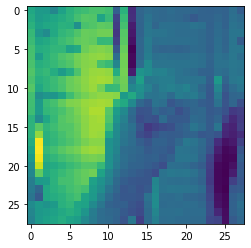

In [38]:
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn, net)
# Запускаем
gesture_list = fcd.run()

In [32]:
# print(gesture_list)

In [39]:
# set(gesture_list)